# Construct the training data into Data format

In [1]:
import sys
sys.path.append("../src")

import torch
import pandas as pd
import numpy as np
from ast import literal_eval
from collections import Counter
from torch_geometric.data import Data
from reachability_model_function import build_graph_reachability
from dataset_function import generate_labeled_route_no_sides
from torch_geometric.loader import DataLoader
from reachability_model_function import ReachabilityGNN
import torch.nn as nn

In [2]:
dataset = pd.read_csv("../data/reachability_dataset.csv")

In [3]:
for name in dataset.columns:
    dataset[name] = dataset[name].apply(literal_eval)

In [4]:
# graph_list: each graph is a training sample
graph_list = []

for _, row in dataset.iterrows():
    labels = generate_labeled_route_no_sides(row["route"], row["hands"], row["feet"], row["climber"])
    if labels.count(0) / len(labels) < 0.95:
        data = build_graph_reachability(row["route"], row["hands"], row["feet"], row["climber"], labels)
        graph_list.append(data)

In [6]:
len(graph_list)

89898

In [7]:
# Save the graph_list to local
torch.save(graph_list, "graph_list_global.pt")

# Train the Model

In [2]:
# Load pt file
graph_list = torch.load("graph_list_global.pt")

C:\Users\guanj\AppData\Local\Temp\ipykernel_11820\1285557832.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_list = torch.load("graph_list_global.pt")


In [8]:
all_labels = torch.cat([g.y for g in graph_list])
counts = Counter(all_labels.tolist())
total = sum(counts.values())

max_cap = 5
weights = [min(np.log(total / (counts.get(i, 1) + 1)), max_cap) for i in range(4)]
weights = torch.tensor(weights, dtype=torch.float)

print("Used Weights:", weights)

Used Weights: tensor([0.3115, 1.8776, 5.0000, 2.1821])


In [9]:
# shuffle=True: Shuffle the order of the graph at each epoch to enhance the model's generalisation ability.
loader = DataLoader(graph_list, batch_size=8, shuffle=True)
model = ReachabilityGNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss(weight=weights)

for epoch in range(30):
    total_loss = 0
    model.train()
    for batch in loader:
        out = model(batch)
        loss = loss_fn(out, batch.y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

Epoch 0, Loss: 6840.6453
Epoch 1, Loss: 5669.7139
Epoch 2, Loss: 5311.8809
Epoch 3, Loss: 5059.2265
Epoch 4, Loss: 4906.6935
Epoch 5, Loss: 4807.4663
Epoch 6, Loss: 4720.6136
Epoch 7, Loss: 4652.9888
Epoch 8, Loss: 4584.9444
Epoch 9, Loss: 4515.4339
Epoch 10, Loss: 4464.4576
Epoch 11, Loss: 4446.1432
Epoch 12, Loss: 4388.8969
Epoch 13, Loss: 4371.1154
Epoch 14, Loss: 4342.6801
Epoch 15, Loss: 4313.9652
Epoch 16, Loss: 4281.6265
Epoch 17, Loss: 4270.4251
Epoch 18, Loss: 4230.9738
Epoch 19, Loss: 4235.6031
Epoch 20, Loss: 4202.6762
Epoch 21, Loss: 4177.9872
Epoch 22, Loss: 4170.6156
Epoch 23, Loss: 4152.2022
Epoch 24, Loss: 4147.4835
Epoch 25, Loss: 4147.0774
Epoch 26, Loss: 4128.1184
Epoch 27, Loss: 4111.0372
Epoch 28, Loss: 4093.9138
Epoch 29, Loss: 4085.8830


In [11]:
from torch_geometric.data import Batch
from collections import Counter

model.eval()
all_preds = []

with torch.no_grad():
    for g in graph_list[:30]:
        batch = Batch.from_data_list([g])     # ✅ 将单图转换为 Batch
        out = model(batch)                    # ✅ 可以调用 model.forward(data)
        pred = out.argmax(dim=1)
        all_preds.extend(pred.tolist())

print("Distribution of Predictions:", Counter(all_preds))

Distribution of Predictions: Counter({0: 1207, 1: 639, 3: 419, 2: 15})


In [ ]:
model.eval()
with torch.no_grad():
    preds = []
    for g in graph_list[:30]:
        p = model(g).argmax(dim=1)
        preds.extend(p.tolist())

print("Distribution of Predictions:", Counter(preds))

In [12]:
torch.save(model.state_dict(),"reachability_model4.pt")

In [13]:
# Load the model
model = ReachabilityGNN()
model.load_state_dict(torch.load("reachability_model4.pt"))
model.eval()

C:\Users\guanj\AppData\Local\Temp\ipykernel_19604\4029515660.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("reachability_model4.pt"))


ReachabilityGNN(
  (conv1): GCNConv(6, 64)
  (conv2): GCNConv(64, 64)
  (climber_embed): Linear(in_features=4, out_features=64, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [2]:
graph_list = torch.load("graph_list.pt")

C:\Users\guanj\AppData\Local\Temp\ipykernel_14260\2863085696.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_list = torch.load("graph_list.pt")


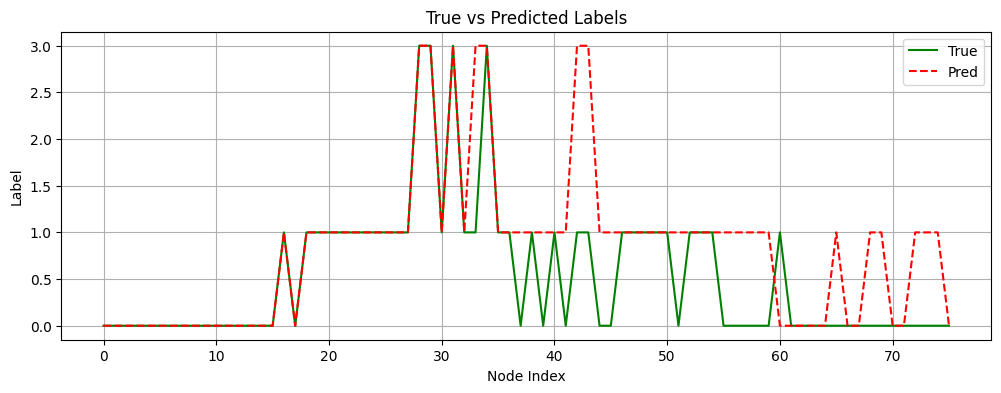

In [22]:
import matplotlib.pyplot as plt
graph = graph_list[2450]
batch = Batch.from_data_list([graph])  # ✅ 构造成带 batch 的图

with torch.no_grad():
    pred_logits = model(batch)
    pred_labels = pred_logits.argmax(dim=1)

# 转 numpy
true = graph.y.cpu().numpy()
pred = pred_labels.cpu().numpy()

# 绘图
plt.figure(figsize=(12, 4))
plt.plot(true, label='True', color='green')
plt.plot(pred, label='Pred', linestyle='--', color='red')
plt.legend()
plt.title("True vs Predicted Labels")
plt.xlabel("Node Index")
plt.ylabel("Label")
plt.grid(True)
plt.show()

In [23]:
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0], dtype=int64)